In [54]:
#%pip install -U albumentations
#%pip install efficientnet_pytorch

# Detection commets  

In [55]:
import os
from os import listdir
from os.path import isfile, join
import shutil
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io.image import read_image
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import cv2

# Utility functions

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

def print_image(sample):
    """
        Print one sample of СometDetectionDataset class.
        For example:  print_image(train[2])
    Args:
        sample: item of СometDetectionDataset class.
    Returns:
        Plot of sample with bounding box.
    """
    fig, ax = plt.subplots(figsize = (9,9))
    
    image = np.moveaxis(sample['image'].numpy(), 0, 2)
    ax.imshow(image)
    
    print(sample['file_name'])
    
    x1_y1 = sample['x1_y1'].numpy()
    x2_y2 = sample['x2_y2'].numpy()
    
    w = abs(x1_y1[0] - x2_y2[0]) * image.shape[0]
    h = abs(x1_y1[1] - x2_y2[1]) * image.shape[1]
    x = min(x1_y1[0],x2_y2[0]) * image.shape[0]
    y = min(x1_y1[1],x2_y2[1]) * image.shape[1]
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
    plt.show()

def show_images_batch(batch):
    """
        Print one batch of samples.
        For example:  show_images_batch(next(iter(train_loader)))
    Args:
        batch: item of DataLoader based on СometDetectionDataset class.
    Returns:
        Plot of samples with bounding boxes.
    """
    img_list = batch['image']
    x1_y1_list = batch['x1_y1']
    x2_y2_list = batch['x2_y2']
    ratio = batch['ratio']
    ratio = torch.unsqueeze(ratio, 1)

    label = batch['label']
    files_name = batch['file_name']

    show_list_images(img_list, x1_y1_list, x2_y2_list, ratio, files_name)

def show_list_images(img_list, x1_y1_list, x2_y2_list, ratio, files_name):
    """
        Utility function for ploting image with bounding box
    """
    fig = plt.figure(figsize = (20,20))
    for i in range(len(img_list)):
        ax = fig.add_subplot(4, 4, i+1)
        image = np.moveaxis(img_list[i].cpu().detach().numpy(), 0, 2)
        ax.imshow(image)
        x1_y1 = x1_y1_list[i].cpu().detach().numpy()
        x2_y2 = x2_y2_list[i].cpu().detach().numpy()
        ratio_str = ratio[i].cpu().detach().numpy()[0]
        w = abs(x1_y1[0] - x2_y2[0]) * image.shape[0]
        h = abs(x1_y1[1] - x2_y2[1]) * image.shape[1]
        x = min(x1_y1[0],x2_y2[0]) * image.shape[0]
        y = min(x1_y1[1],x2_y2[1]) * image.shape[1]
        
        ax.add_patch(patches.Rectangle((x,y),w,h,
                     fill=False, edgecolor='red', lw=2))
        file_path, file_name = os.path.split(files_name[i])
        
        ax.set_title('File {0} ratio {1:.5f}'.format(file_name,ratio_str))

    plt.show()
    
def get_commet_detection(path_to_image, path_to_model):
    """
        Predict bounding box for comet in astro image.
        
    Args:
        path_to_image: path to astro image with comet
        path_to_model: path to pre-trained model
    Returns:
        Plot image and bounding box.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import patches
    import torch
    from torchvision.transforms import ToTensor
    from PIL import Image
    
    pil_img = Image.open(path_to_image).convert('RGB')
    img_resize = pil_img.resize((500,500))
    
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(img_resize)

    image = ToTensor()(np.array(img_resize))
    image = image.unsqueeze(0)

    model = torch.load(path_to_model).to(device='cpu')
    model.eval()

    predictions = model.to(device='cpu')(image)
    
    with torch.no_grad():
        x1_y1 = predictions[:, :2]
        x2_y2 = predictions[:, 2:4]
        
        w = abs(x1_y1[0][0] - x2_y2[0][0]) * img_resize.size[0]
        h = abs(x1_y1[0][1] - x2_y2[0][1]) * img_resize.size[1]
        x = min(x1_y1[0][0],x2_y2[0][0]) * img_resize.size[0]
        y = min(x1_y1[0][1],x2_y2[0][1]) * img_resize.size[1]
        
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
           
    plt.show()  

# 1 Dataset и Dataloader

In [57]:
class СometDetectionDataset(Dataset):
    
    def __init__(self, xml_file, img_dir,
                 shuffle=False, train=None,
                 test_size=0.05, transform=None, augmentation_transform=None):
        self.img_dir = img_dir 
        self.transform = transform
        self.augmentation_transform = augmentation_transform
        self.data = self._get_dataset_from_xml_cvat_file(xml_file,shuffle,train,test_size)    
    
    def _get_ratio_means_image_bbox(self, image, x1, y1, x2, y2):
        """
            Calc ratio between average signal in bounding box and avg signal whole image
        """
        x_min = min(int(x1),int(x2))
        y_min = min(int(y1),int(y2))
        x_max = max(int(x1),int(x2))
        y_max = max(int(y1),int(y2))
        # get bounding box by coordinates
        bounding_box = image[:,y_min:y_max,x_min:x_max]
        # calc ratio
        mean_all_image = image.mean()
        mean_bounding_box = bounding_box.mean()
        return mean_bounding_box / (mean_all_image + mean_bounding_box)  

    def _get_dataset_from_xml_cvat_file(self,xml_file, shuffle, train, test_size):
        """
            Parse xml file with coordinates of bounding box
        """
        import xml.etree.ElementTree as ET
        import pandas as pd
        from sklearn.model_selection import train_test_split

        df = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for file_item in root.iter(tag='image'):

            name_file = file_item.attrib['name']
            box_info = file_item.findall('box')
            if len(box_info)==0:
                continue
            else:
                box_info = box_info[0]
                x1 = float(box_info.get('xtl'))
                y1 = float(box_info.get('ytl'))
                x2 = float(box_info.get('xbr'))
                y2 = float(box_info.get('ybr'))
                df.loc[len(df),:] = [os.path.join(self.img_dir,name_file), x1, y1, x2, y2, 1]
        # return all dataset
        if train==None:
            return df
        # split dataset to train and test
        train_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=42)
        if train==True:
            if not self.augmentation_transform==None:
                # create dir for augment images
                path_to_save_aug = os.path.join(self.img_dir + 'aug/')
                if not os.path.exists(path_to_save_aug):
                    os.mkdir(path_to_save_aug)
                else:
                    # clear previous images 
                    shutil.rmtree(path_to_save_aug)
                    os.mkdir(path_to_save_aug)
                    
                df_aug = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
                for index, row in train_df.iterrows():
                    for j in range(len(self.augmentation_transform)):
                        image = cv2.imread(row.file_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        bboxes = [[row.x1, row.y1, row.x2, row.y2,1]]
                        transformed = self.augmentation_transform[j](image=image, bboxes=bboxes)
                        transformed_image = transformed['image']

                        transformed_bboxes = transformed['bboxes']
                        (file_name, ext) = os.path.splitext(row.file_name)
                        new_file_name = file_name.split('/')[-1] + f'_aug{j+1}' + ext
                        new_file_name = new_file_name
                        new_file_name = os.path.join(path_to_save_aug, new_file_name)
                        cv2.imwrite(new_file_name, transformed_image)
                        df_aug.loc[len(df_aug),:] = [new_file_name,
                                                         transformed_bboxes[0][0],transformed_bboxes[0][1],
                                                         transformed_bboxes[0][2],transformed_bboxes[0][3],
                                                         transformed_bboxes[0][4]]
                if len(df_aug) > 0:
                    train_df = pd.concat([train_df,df_aug])
            return train_df.reset_index()
        else:
            return test_df.reset_index()
        return df
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        result = {}
        # get path to image
        row = self.data.loc[idx]
        
        img_path = row.file_name
        if os.path.exists(img_path):
            # read image to torch tensor 
            image = read_image(img_path)
            # if need do transform data
            if self.transform:
                image = self.transform(image)
            # normalize image
            min_max_norm = (image - image.min())/(image.max() - image.min())
            result['image'] = min_max_norm
            # coordinates of bounding box have been converted to percent of image size
            result['x1_y1'] = torch.FloatTensor([row.x1/image.shape[1],row.y1/image.shape[2]])
            result['x2_y2'] = torch.FloatTensor([row.x2/image.shape[1],row.y2/image.shape[2]])
            # add human experience: mean signal in bounding box must much differ at mean signal all image
            result['ratio'] = self._get_ratio_means_image_bbox(min_max_norm,row.x1,row.y1,row.x2,row.y2)
            result['label'] = torch.LongTensor(row.label)
        else:
            result['image'] = None
            result['x1_y1'] = None
            result['x2_y2'] = None
            result['label'] = None
        # utility feature for printing images 
        result['file_name'] = row.file_name
        return result

In [58]:
# add augmentation
aug_transform_1 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.2),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_2 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.5),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_3 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5), A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.7),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))
aug_transform_4 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.25), A.HorizontalFlip(p=0.25),
                           A.RandomBrightnessContrast(p=0.3),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

                      


train = СometDetectionDataset(xml_file='annotations2.xml', img_dir='./resize_images/',
                              train=True, augmentation_transform = [aug_transform_1,aug_transform_2,aug_transform_3,aug_transform_4])
test = СometDetectionDataset(xml_file = 'annotations2.xml', img_dir='./resize_images/', train=False)
print(f'Train size {len(train)}, test size {len(test)}')

Train size 475, test size 5


In [59]:
train_loader = DataLoader(train, batch_size=4, drop_last=True )
test_loader = DataLoader(test, batch_size=2, drop_last=True)

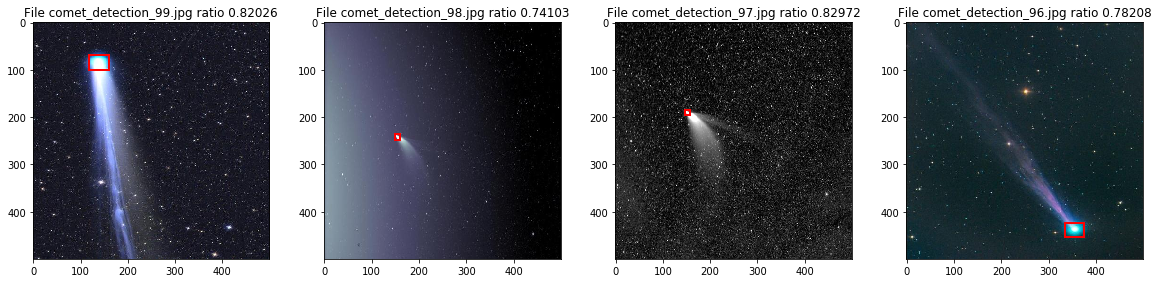

In [60]:
# check if all images and bounding in place
show_images_batch(next(iter(train_loader)))

# 2. Train model

In [61]:
def train_model(net, model_name):
    # import warnings filter
    from warnings import simplefilter
    # ignore all future warnings
    simplefilter(action='ignore', category=FutureWarning)

    loss_MSE = torch.nn.MSELoss()
    loss_MAE = torch.nn.L1Loss()
    #loss_function_bce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    net = net.to(device)

    n_epoch = 500
    for epoch in tqdm(range(n_epoch),total=n_epoch):
        net.train()
        epoch_loss = 0.

        for batch in train_loader:
            images = batch['image']
            x1_y1 = batch['x1_y1']
            x2_y2 = batch['x2_y2']
            ratio = batch['ratio']

            images = images.to(device,dtype=torch.float)
            x1_y1 = x1_y1.to(device)
            x2_y2 = x2_y2.to(device)
            ratio = torch.unsqueeze(ratio, 1)
            ratio = ratio.to(device)
            
            optimizer.zero_grad()
            predictions = net(images)
            
            loss = (loss_MAE(predictions[:, :2], x1_y1) + \
                loss_MAE(predictions[:, 2:4], x2_y2) + \
                2*loss_MSE(predictions[:, 4:5], ratio))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        clear_output(wait=True)
        epoch_loss = epoch_loss / len(train_loader)
        print(f'Train: loss = {epoch_loss}')
        df.loc[len(df),:] = [model_name,epoch,epoch_loss]

    torch.save(net, f'comet_detection_{model_name}')

    net.eval()
    epoch_loss = 0.
    for batch in test_loader:
        # batch data to cuda
        images = batch['image']
        x1_y1 = batch['x1_y1']
        x2_y2 = batch['x2_y2']
        ratio = batch['ratio']
        files_name = batch['file_name']
        
        images = images.to(device,dtype=torch.float)
        x1_y1 = x1_y1.to(device)
        x2_y2 = x2_y2.to(device)
        ratio = torch.unsqueeze(ratio, 1)
        ratio = ratio.to(device)
        
        predictions = net(images)
        
        x1_y1_pred = predictions[:, :2]
        x2_y2_pred = predictions[:, 2:4]
        ratio_pred =  predictions[:, 4:5]

        # calc loss
        with torch.no_grad():
            loss = (loss_MAE(x1_y1_pred, x1_y1) + \
                loss_MAE(x2_y2_pred, x2_y2) + \
                2*loss_MSE(ratio_pred, ratio))
                
        epoch_loss += loss.item()
        # show detect bounding box
        show_list_images(batch['image'], x1_y1_pred, x2_y2_pred, ratio_pred, files_name)

    print(f'Test: loss function {epoch_loss / len(test_loader)}')

In [62]:
df = pd.DataFrame(columns=['model','n_epoch','loss'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2.1 Resnet18

%%time
from torchvision.models import resnet18
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=5, bias=True)

train_model(net, 'resnet_18')

get_commet_detection('./S3-Panstarrs-July-15-Michael-Jaeger-STv1.jpg', './comet_detection_resnet_18')

## 2.2 Efficient net




100%|██████████| 500/500 [2:30:14<00:00, 18.03s/it]Train: loss = 0.03265251096148612



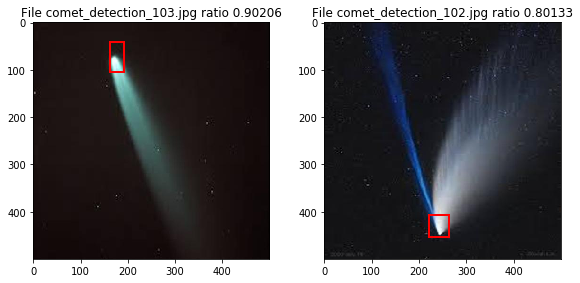

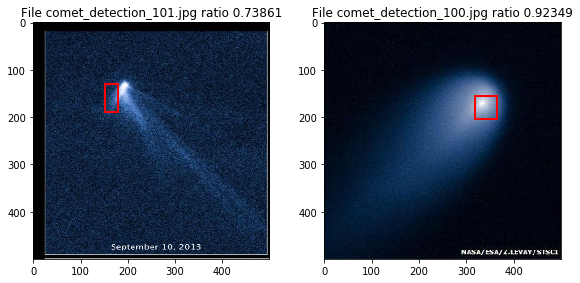

Test: loss function 0.07784644141793251
CPU times: user 9h 29min 34s, sys: 31min 5s, total: 10h 40s
Wall time: 2h 30min 17s


In [63]:
%%time
from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained('efficientnet-b0')
net._fc = torch.nn.Linear(in_features=1280, out_features=5, bias=True)

train_model(net, 'efficient_net')

(500, 500)
tensor(140.9240) tensor(334.0747) tensor(39.3466) tensor(42.1807)


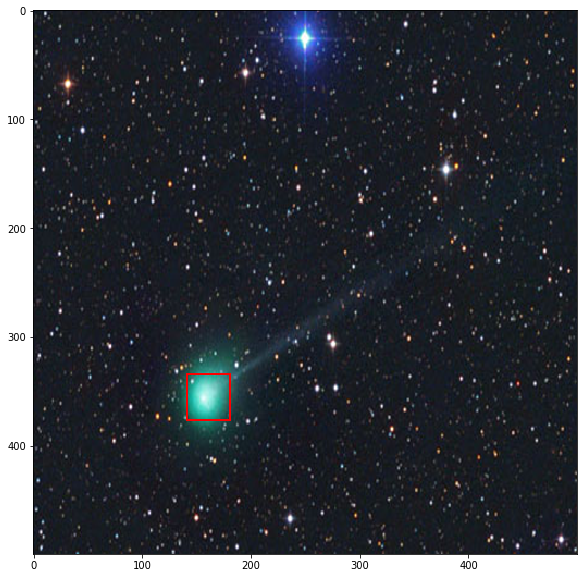

In [64]:
get_commet_detection('./S3-Panstarrs-July-15-Michael-Jaeger-STv1.jpg', './comet_detection_efficient_net')

(500, 500)
tensor(216.3533) tensor(229.5351) tensor(29.5292) tensor(41.4667)


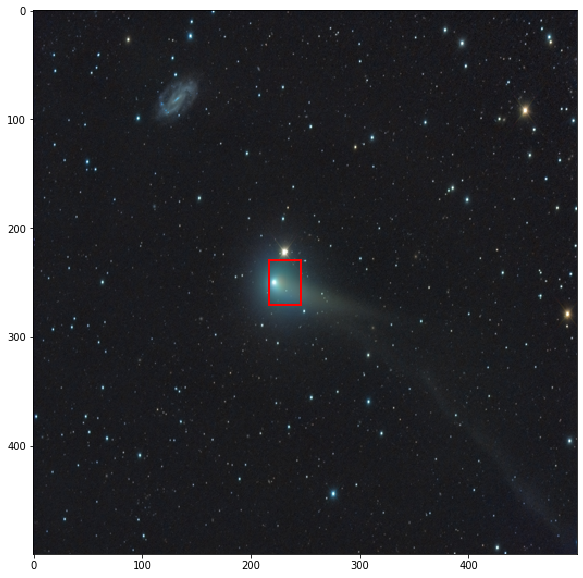

In [67]:
get_commet_detection('./PanstarssN3319Falesiedi.jpg', './comet_detection_efficient_net')

## Resnet VS efficient_net

In [65]:
import matplotlib.pyplot as plt

def plot_training_curves(training, title):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(training['n_epoch'],training['loss'])
    ax.grid()
    ax.set_title(title)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    plt.show()
df.to_csv('loss_history.csv',index=False)

plot_training_curves(df[df.model=='resnet_18'], title='resnet_18')

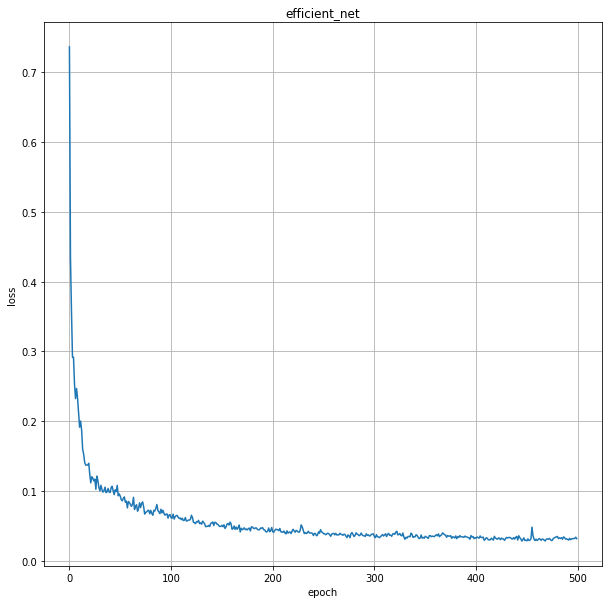

In [66]:
plot_training_curves(df[df.model=='efficient_net'],title='efficient_net')